# 单因子有效性检验

根据现代投资理论，资产的收益是由承担一定的风险换来的，但是每个时期影响资产收益的风险因子使不同的，有的风险因子有效，有的无效，所以在确定多因子量化模型前，首先需要筛选出最近一段时间在市场中影响收益的风险因子（即在当前时间段有效的因子）。

这个notebook使用了两种单因子有效性检验的方法：
- 回归法
- 因子IC值分析

数据源：
深信服（巨潮资讯）的日线数据，公司基本信息以及指数数据。

下面的例子是针对“市盈率”做有效性检验，检验其他因子的有效性也可以用相同的方法。

In [492]:
%matplotlib inline

In [493]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [494]:
data_root = "/home/chaocjia/quant/data"

In [495]:
bar_1d_file = "bar_1d.parquet"
company_info_file = "company_info.parquet"
daily_index_file = "daily_index.parquet"
index_1d_file = "index_1d.parquet"
trade_cal_file = "trade_cal.parquet"

In [496]:
# 读取股票日线数据，利用收盘价和发行总股本计算市值
# F007N: 收盘价   F020N: 发行总股本
bar_1d = pd.read_parquet(os.path.join(data_root, bar_1d_file))
bar_1d = bar_1d.assign(market_value=bar_1d["F007N"]*bar_1d["F020N"])
# 过滤掉市值为0的股票（有些新股上市是没有市值的）
bar_1d = bar_1d[~(bar_1d["market_value"]==0)]
bar_1d = bar_1d[["SECCODE", "TRADEDATE", "F007N", "F026N", "market_value"]]

In [497]:
# 读取公司基本信息，主要为了获取公司所属行业信息
# 这里选用的标准为申万一级行业分类标准
# F033V: 行业代码  F034V: 行业名称
company_info = pd.read_parquet(os.path.join(data_root, company_info_file), columns=["SECCODE", "F033V", "F034V"])

In [498]:
# 读取沪深300指数数据，399300为沪深300指数代码
# F006N: 收盘指数
hs300_1d = pd.read_parquet(os.path.join(data_root, index_1d_file), columns=["SECCODE", "TRADEDATE", "INDEXCODE", "F006N"])
hs300_1d = hs300_1d[hs300_1d["INDEXCODE"]=="399300"]

In [499]:
# 将公司行业信息追加到日线数据中
bar_1d_compond = pd.merge(bar_1d, company_info, how="left", on="SECCODE")

In [500]:
# 选取2016-08-31这一天的A股交易数据
bar_1d_2016_08_31 = bar_1d_compond[bar_1d_compond["TRADEDATE"]=="2016-08-31"]

In [501]:
# 计算2016-08-31这一天各个行业的市盈率均值
# F033V: 行业代码  F026N: 市盈率
PE = bar_1d_2016_08_31.groupby("F033V").F026N.agg(["mean"])

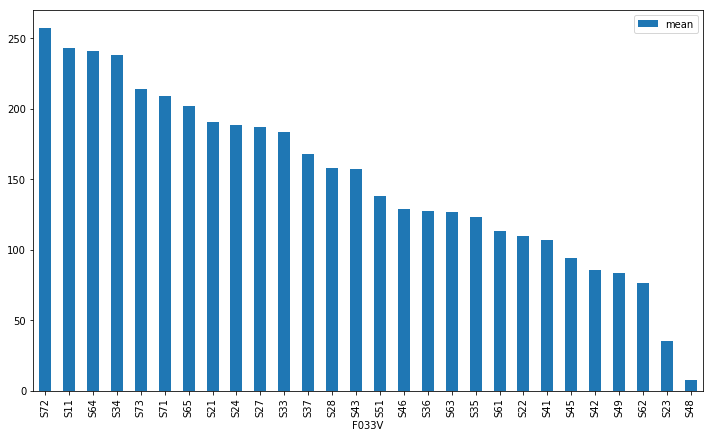

In [502]:
PE.sort_values(by="mean", ascending=False).plot(kind="bar", figsize=(12,7))

**上图可以看出，不同行业的市盈率均值不一样。**  
2016-08-31这一天排名前五的行业为：
- s72: 传媒
- s11: 农林牧渔
- s64: 机械设备
- s34: 食品饮料
- s73: 通信  

市盈率最低的为：  
s48: 银行业

## 单因子测试流程

### 回归法
回归法是一种最常用的测试因子有效性的方法，具体做法是将因子在第T期的暴露度与T+1期的股票收益进行线性回归，所得到的回归系数即为因子在T期的因子收益率，同时还能得到该因子收益率在本期回归中的显著度水平——t值。我们的回归模型为： 

$r^{T+1}_i=\sum_{j}X^T_jf^T_{ji}+X^T_dd^T_i+u^T_i$

- $r^{T+1}_i$: 股票i在第T +1期的收益率
- $d^T_i$: 股票i在第T期因子d上的暴露度
- $f^T_{ji}$: 股票i在第T期第j个行业因子上的暴露度(属于该行业则为1，否则为0)
- $X^T_j(X^T_d)$: 第T期第j个行业因子(或因子d)的因子收益率，需回归拟合
- $u^T_i$: 股票i在第T期的残差收益率

在所有截面期上，我们对因子d进行回归测试，能够得到该因子的因子收益率序列（即所有截面期回归系数$𝑋^𝑇_d$构成的序列）和对应的t值序列。t值指的是对单个回归系数$𝑋^𝑇_d$的t检验统计量，描述的是单个变量显著性，t值的绝对值大于临界值说明该变量是显著的，即该解释变量（T期个股在因子d的暴露度）是真正影响因变量（T + 1期个股收益率）的一个因素。

一般t值绝对值大于 2 我们就认为本
期回归系数$𝑋^𝑇_d$是显著异于零的（也就是说，本期因子 d 对下期收益率具有显著的解释作用）。
注意，我们在回归模型中加入了行业因素，能在一定程度上规避行业因素对估值因子的影响。
并且回归法单因子测试中并未对市值因素的影响进行调整，但是在后续计算因子 IC 值的部
分会做一些调整。

#### 测试模型构建方法

1. 股票池：全A股
2. 回溯区间：2005-04-29 至 2016-08-31。
3. 截面期：每个自然月的最后一个交易日计算因子暴露度，与下一整个自然月的个股超额收益（以沪深300指数为基准）进行回归。
4. 数据处理方法：
   - 中位数去极值：设第T期某因子在所有个股上的暴露度序列为$𝐷_𝑖$，$𝐷_𝑀$为该序列中位数，$𝐷_{𝑀1}$为序列$|𝐷_𝑖 −𝐷_𝑀|$的中位数，则将序列$𝐷_𝑖$中所有大于$𝐷_𝑀 +5𝐷_{𝑀1}$的数重设为$𝐷_𝑀 +5𝐷_{𝑀1}$，将序列$𝐷_𝑖$中所有小于$𝐷_𝑀 − 5𝐷_{𝑀1}$的数重设为$𝐷_𝑀 −5𝐷_{𝑀1}$；
   - 标准化：将去极值处理后的因子暴露度序列减去其现在的均值、除以其标准差，得到一个新的近似服从N(0,1)分布的序列，这样做可以让不同因子的暴露度之间具有可比性；
   - 缺失值处理：得到新的因子暴露度序列后，将因子暴露度缺失的地方设为 0（这里解释一下，由于不同因子可能在不同个股处存在缺失值，若不对缺失值进行处理则每个单因子回归的票池并不完全相同，不同单因子回归结果的可比性较差，但如果将所有出现缺失值的个股都从回归票池中剔除，当数据源质量不佳时可能会造成票池大幅减少，回归结果同样不可信，所以这里折中处理，将因子暴露度缺失的地方设为新序列的均值，即设为零，可视作当存在缺失值时我们认为此个股的因子值与全市场平均情况相同，即持中性看法）。
5. 回归权重：由于普通最小二乘回归（OLS）可能会夸大小盘股的影响（因为小盘股的估值等因子出现极端值概率较大，且小盘股数目很多，但占全市场的交易量比重较小），并且回归可能存在异方差性，故我们参考Barra手册，采用加权最小二乘回归（WLS），使用个股流通市值的平方根作为权重，此举也有利于消除异方差性。
6. 因子评价方法：
   - t 值序列绝对值平均值——因子显著性的重要判据；
   - t 值序列绝对值大于 2 的占比——判断因子的显著性是否稳定；
   - 因子收益率序列平均值，以及该均值零假设检验的 t 值——判断因子收益率序列是否方向一致，并且显著不为零；
   - t 值序列均值的绝对值除以 t 值序列的标准差——结合显著性和波动性，辅助判断因子是否有效、稳健。

In [503]:
start_date = "2005-04-29"
end_date = "2016-08-31"

In [504]:
# 筛选出给定时间段的日线数据
bar_1d_compond_subset = bar_1d_compond[(bar_1d_compond["TRADEDATE"]>=start_date)&(bar_1d_compond["TRADEDATE"]<=end_date)]

In [505]:
bar_1d_compond_subset = bar_1d_compond_subset.assign(YEAR=bar_1d_compond_subset["TRADEDATE"].map(lambda x: x.split("-")[0]),
                                                     MONTH=bar_1d_compond_subset["TRADEDATE"].map(lambda x: x.split("-")[1]))

In [506]:
# 筛选出每只股票各个月份最后一个交易日的数据
end_of_month = bar_1d_compond_subset.groupby(["SECCODE", "YEAR", "MONTH"]).tail(1)

In [507]:
# 筛选出每只股票各个月份第一个交易日的数据
start_of_month = bar_1d_compond_subset.groupby(["SECCODE", "YEAR", "MONTH"]).head(1)

In [508]:
# 计算各个股票当月的累计收益率
columns_used = ["SECCODE", "F007N", "YEAR", "MONTH"]
return_of_month = pd.merge(start_of_month[columns_used], end_of_month[columns_used], how="inner", on=["SECCODE", "YEAR", "MONTH"])
return_of_month = return_of_month.assign(return_rate=(return_of_month["F007N_y"]-return_of_month["F007N_x"])/return_of_month["F007N_x"])
return_of_month = return_of_month.drop(columns=["F007N_x", "F007N_y"])

In [509]:
regression_df = pd.merge(end_of_month, return_of_month, how="inner", on=["SECCODE", "YEAR", "MONTH"])

In [510]:
# 将收益率序列进行错位，以便各个股票在每个月最后一个交易日对应的是下一个月的累计收益率
return_shifted = regression_df.groupby(["SECCODE"])["return_rate"].transform(lambda x: x.shift(-1))
regression_df = regression_df.assign(return_rate=return_shifted)
regression_df = regression_df.dropna(subset=["return_rate"])

In [511]:
# 筛选给定时间段沪深300的数据
hs300_1d_subset = hs300_1d[(hs300_1d["TRADEDATE"]>=start_date)&(hs300_1d["TRADEDATE"]<=end_date)]
hs300_1d_subset = hs300_1d_subset.assign(YEAR=hs300_1d_subset["TRADEDATE"].map(lambda x: x.split("-")[0]),
                                         MONTH=hs300_1d_subset["TRADEDATE"].map(lambda x: x.split("-")[1]))

In [512]:
# 筛选出沪深300每月第一个交易日和最后一个交易日的数据
market_end_of_month = hs300_1d_subset.groupby(["YEAR", "MONTH"]).tail(1)
market_start_of_month = hs300_1d_subset.groupby(["YEAR", "MONTH"]).head(1)

In [513]:
# 计算沪深300当月的累计收益率
columns_used = ["F006N", "YEAR", "MONTH"]
market_return_of_month = pd.merge(market_start_of_month[columns_used], market_end_of_month[columns_used], how="inner", on=["YEAR", "MONTH"])
market_return_of_month = market_return_of_month.assign(market_return_rate=(market_return_of_month["F006N_y"]-market_return_of_month["F006N_x"])/market_return_of_month["F006N_x"])
market_return_of_month = market_return_of_month.drop(columns=["F006N_x", "F006N_y"])

In [514]:
# 将收益率序列进行错位，以便对应下一个月的累计收益率
market_return_of_month = market_return_of_month.assign(market_return_rate=market_return_of_month["market_return_rate"].shift(-1))
market_return_of_month = market_return_of_month.dropna(subset=["market_return_rate"])
# market_return_of_month.head()

In [515]:
# 计算各个股票在下个月的超额收益率
regression_df = pd.merge(regression_df, market_return_of_month, how="left", on=["YEAR", "MONTH"])
regression_df = regression_df.assign(excess_return=regression_df["return_rate"]-regression_df["market_return_rate"])
# regression_df.head()

In [516]:
# 根据上面的去极值规则编写的函数
def remove_peak(x):
    dm = x.median()
    dm1 = (x-dm).abs().median()
    def replace(y):
        if y > dm+5*dm1:
            y = dm+5*dm1
        elif y < dm-5*dm1:
            y = dm-5*dm1
        return y
    return x.map(replace)

In [517]:
# TODO: 是否按行业去极值还有待商定
PE_remove_peak = regression_df.groupby(["YEAR", "MONTH"])["F026N"].transform(remove_peak)
regression_df = regression_df.assign(F026N=PE_remove_peak)

In [518]:
# 标准化
PE_normalization = regression_df.groupby(["YEAR", "MONTH"])["F026N"].transform(lambda x: (x-x.mean())/x.std())
regression_df = regression_df.assign(F026N=PE_normalization)
# 缺失值填充
regression_df = regression_df.fillna(value={"F026N": 0})
# 对市值取log，进行一下平滑处理
regression_df = regression_df.assign(market_value=np.log(regression_df["market_value"]))

In [519]:
# 以行业和处理后的因子值作为自变量对超额收益进行加权最小二乘回归
def weighted_least_square(df):
    WLS_df = pd.get_dummies(df[["F033V", "F026N", "excess_return", "market_value"]])
    WLS_model = sm.WLS(WLS_df["excess_return"], WLS_df.drop(columns=["excess_return", "market_value"]), weighs=WLS_df["market_value"])
    model_res = WLS_model.fit()
    return model_res

In [520]:
# 收集因子收益率序列和t值序列
risk_return_series = []
t_series = []
for trade_date, data in regression_df.groupby("TRADEDATE"):
    model_res = weighted_least_square(data)
    risk_return_series.append(model_res.params["F026N"])
    t_series.append(model_res.tvalues["F026N"])

/home/chaocjia/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1510: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/home/chaocjia/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1510: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/home/chaocjia/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1181: RuntimeWarning: invalid value encountered in multiply
  cov_p = self.normalized_cov_params * scale


- t 值序列绝对值平均值——因子显著性的重要判据；
- t 值序列绝对值大于 2 的占比——判断因子的显著性是否稳定；
- 因子收益率序列平均值，以及该均值零假设检验的 t 值——判断因子收益率序列是否方向一致，并且显著不为零；
- t 值序列均值的绝对值除以 t 值序列的标准差——结合显著性和波动性，辅助判断因子是否有效、稳健。

In [521]:
risk_return_series = pd.Series(risk_return_series)
t_series = pd.Series(t_series)

In [522]:
# 计算上述提到的四种统计值
t_series_abs = t_series.abs()
t_mean = t_series_abs.mean()
t_rate = len(t_series_abs[t_series_abs>2])/len(t_series_abs)
t_stable = t_series.mean()/t_series.std()
risk_return_mean = risk_return_series.mean()
print("t_mean: {}".format(t_mean))
print("t_rate: {}".format(t_rate))
print("t_stable: {}".format(t_stable))
print("risk_return_mean: {}".format(risk_return_mean))

t_mean: 0.5840303756150828
t_rate: 0.05391912131802296
t_stable: -0.023782905947345865
risk_return_mean: -0.06568740228802973


## 因子IC值分析

因子的IC值是指因子在第T期的暴露度与T+1期的股票收益的相关系数，即： 

$IC^T_d=corr(R^{T+1}, d^T)$

其中，$IC^T_d$代表因子d在第T期的IC值，$R^{T+1}$代表所有个股第T+1期的收益率向量，$d^T$代表所有个股第T期在因子d上的暴露度向量。


#### 测试模型构建方法

1. 股票池、回溯区间、截面期均与回归法相同。
2. 因子值在去极值、标准化、去空值处理后，在截面期上用其做因变量对市值因子及行业因子（哑变量）做线性回归，取残差作为因子值的一个替代。这样做可以消除行业因素和市值因素对因子的影响。计算残差序列和T+1期股票收益序列的相关系数作为T期因子IC值。
3. 因子评价方法：
   - IC 值序列的均值大小——因子显著性；
   - IC 值序列的标准差——因子稳定性；
   - IR 比率（IC 值序列均值与标准差的比值）——因子有效性；
   - IC 值序列大于零的占比——因子作用方向是否稳定。

In [523]:
# 计算因子IC值
def IC(df):
    OLS_df = pd.get_dummies(df[["F026N", "F033V", "market_value", "excess_return"]])
    OLS_model = sm.OLS(OLS_df["F026N"], OLS_df.drop(columns=["F026N", "excess_return"]))
    model_res = OLS_model.fit()
    y_prediction = OLS_model.predict(model_res.params, OLS_df.drop(columns=["F026N", "excess_return"]))
    OLS_df = OLS_df.assign(F026N=df["F026N"]-y_prediction)
    corr_df = OLS_df[["F026N", "excess_return"]].corr()
    return corr_df.iloc[0,1]

In [524]:
IC_series = []
for trade_date, data in regression_df.groupby("TRADEDATE"):
    IC_series.append(IC(data))

In [525]:
IC_series = pd.Series(IC_series)

因子评价方法：  
a) IC 值序列的均值大小——因子显著性；  
b) IC 值序列的标准差——因子稳定性；  
c) IR 比率（IC 值序列均值与标准差的比值）——因子有效性；  
d) IC 值累积曲线——随时间变化效果是否稳定；  
e) IC 值序列大于零的占比——因子作用方向是否稳定  

In [527]:
IC_mean = IC_series.mean()
IC_std = IC_series.std()
IR_rate = IC_mean / IC_std
IC_rate = len(IC_series[IC_series>0])/len(IC_series)
print("IC_mean: {}".format(IC_mean))
print("IC_std: {}".format(IC_std))
print("IR_rate: {}".format(IR_rate))
print("IC_rate: {}".format(IC_rate))

IC_mean: -0.009661705478322388
IC_std: 0.6514955639506431
IR_rate: -0.014830040314832217
IC_rate: 0.31852221667498753


根据上述方法选取不同的阈值，可以初步筛选出有效的因子，为了进一步检验因子的有效型还需要在这段时间内进行回测。
## 分层模型回测

依照因子值对股票进行打分，构建投资组合回测，是最直观的衡量指标优劣的手段。一般来
说，通过回归法和计算因子 IC 值都无法确定因子的单调性（例如，某因子值排名在中间 1/3
的个股表现比前 1/3 和后 1/3 的个股表现要好），但是分层回测法是可以确定因子单调性的。
分层回测法逻辑简单，结果清晰，操作方便，并且具有能区分因子单调性的独特优势，是接
受度非常高的一种单因子测试手段。

TODO: 后续会推出这块的代码实现...